In [2]:
from apportionment import *

In [3]:
# raw2visualisable(f"1m-2023hb.csv", weighted=False)
# raw2visualisable(f"1m-2023hb.csv", weighted=False, only_electable=True)
# raw2visualisable(f"1m-2023dh.csv", weighted=False)
# raw2visualisable(f"1m-2023dh.csv", weighted=False, only_electable=True)


Peek 1 location for Slovak apportionment: 7864
Peek 2 location for Slovak apportionment: 19517
Peek 1 location for Hagenbach-Bischoff apportionment: 7992
Peek 2 location for Hagenbach-Bischoff apportionment: 19477
Peek 1 location for D'Hondt apportionment: 7838
Peek 2 location for D'Hondt apportionment: 19262


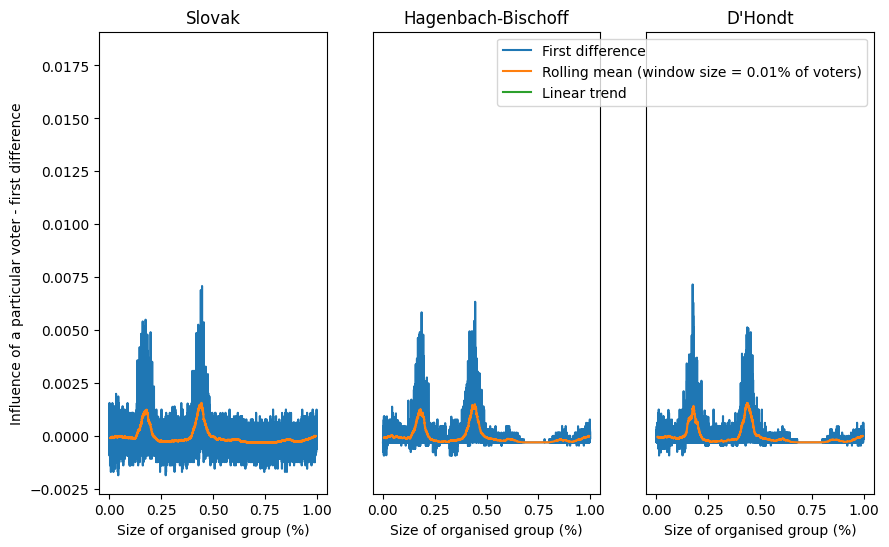

In [4]:
suffixes = ['', 'hb', 'dh']

apport_dict = {
    '' : "Slovak",
    'hb' : "Hagenbach-Bischoff",
    'dh' : "D'Hondt"
    }

fig, axes = plt.subplots(1, 3, figsize=(10, 6))

y_min = float('inf')
y_max = float('-inf')

for suffix in suffixes:
    df = pd.read_csv(f"./vis_data/electable-unweighted-vis-1m-2023{suffix}.csv")
    
    x_values = ((df['samples'] / 1000000) * (100))[:10000]
    y_values = df['diff'][:10000]
    y_vals = y_values - (3 * x_values)
    
    y_deriv = y_vals.diff()
    y_rolling = y_deriv.rolling(window=100, center=True).mean()
    
    y_min = min(y_min, y_deriv.min(), y_rolling.min())
    y_max = max(y_max, y_deriv.max(), y_rolling.max())

for i, (ax, suffix) in enumerate(zip(axes, suffixes)):
    df = pd.read_csv(f"./vis_data/unweighted-vis-1m-2023{suffix}.csv")
    
    x_values = ((df['samples'] / 1000000) * (100))[:10000]
    y_values = df['diff'][:10000]
    y_vals = y_values - (3 * x_values)
    
    y_deriv = y_vals.diff()
    y_rolling = y_deriv.rolling(window=100, center=True).mean()
    
    x = np.arange(0, 1)
    y = 3 * x
    
    ax.plot(x_values, y_deriv, '-', markersize=1, label="First difference")
    ax.plot(x_values, y_rolling, '-', markersize=1, label="Rolling mean (window size = 0.01% of voters)")
    ax.plot(x, y * 0, label='Linear trend')
    
    ax.set_xlabel('Size of organised group (%)')

    ax.set_ylim(y_min, y_max)

    if suffix:
        axes[i].yaxis.set_ticks([])

    if i == 0:
        ax.set_ylabel('Influence of a particular voter - first difference')

    ax.set_title(f'{apport_dict[suffix]}')
    
    max_index = y_rolling[:3000].idxmax()
    print(f'Peek 1 location for {apport_dict[suffix]} apportionment: {int(max_index * (4388872 / 1000000))}')

    max_index = y_rolling.idxmax()
    print(f'Peek 2 location for {apport_dict[suffix]} apportionment: {int(max_index * (4388872 / 1000000))}')

plt.legend()
plt.show()


In [5]:
db_file = 'apportionments.db'

if not os.path.exists(db_file):
    suffixes = ["", "hb", "dh"]

    conn = sqlite3.connect(db_file)
    cur = conn.cursor()
            
    for suffix in suffixes:
        cur.execute(f'''CREATE TABLE IF NOT EXISTS tab{suffix} (
                    iteration_number INTEGER,
                    party_number INTEGER,
                    samples INTEGER,
                    diff INTEGER
                    );''')

        with open(f'./raw_data/1m-2023{suffix}.csv', 'r') as file:
            reader = csv.reader(file)
            next(reader)  # Skip header if exists
            for i, row in enumerate(reader):
                cur.execute(f'''INSERT INTO tab{suffix} (iteration_number, party_number, samples, diff)
                                VALUES (?, ?, ?, ?);''', row)
                
    for suffix in suffixes:
        cur.execute(f'''CREATE TABLE IF NOT EXISTS tab{suffix}coal (
                    iteration_number INTEGER,
                    party_number INTEGER,
                    samples INTEGER,
                    diff INTEGER
                    );''')

        with open(f'./raw_data/1m-2023{suffix}coal.csv', 'r') as file:
            reader = csv.reader(file)
            next(reader)  # Skip header if exists
            for i, row in enumerate(reader):
                cur.execute(f'''INSERT INTO tab{suffix}coal (iteration_number, party_number, samples, diff)
                                VALUES (?, ?, ?, ?);''', row)
            
    conn.commit()
    conn.close()

In [6]:
'''
THIS WAS ALREADY RUN
'''

suffixes = ["", "hb", "dh"]

for suffix in suffixes:
    with sqlite3.connect('apportionments.db') as conn:
        cur = conn.cursor()

        cur.execute(f'''
            SELECT iteration_number, party_number, MIN(samples) 
            FROM tab{suffix}coal 
            WHERE diff < 76 
            GROUP BY iteration_number, party_number;
        ''')

        results = cur.fetchall()

        with open(f'coalitions2023{suffix}.csv', 'w', newline='') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow(['iteration_number', 'party_number', 'lowest_samples'])
            csvwriter.writerows(results)

        # cur = conn.cursor()

        # cur.execute(f'''
        #     SELECT iteration_number, party_number, MIN(samples) 
        #     FROM tab{suffix} 
        #     WHERE diff > 0 
        #     GROUP BY iteration_number, party_number;
        # ''')

        # results = cur.fetchall()

        # with open(f'lowest_samples2023{suffix}.csv', 'w', newline='') as csvfile:
        #     csvwriter = csv.writer(csvfile)
        #     csvwriter.writerow(['iteration_number', 'party_number', 'lowest_samples'])
        #     csvwriter.writerows(results)

        print(f'year 2023{suffix} is done')



year 2023 is done
year 2023hb is done
year 2023dh is done


,iteration_number,party_number,lowest_samples
0,1,0,4.388872
1,1,1,4.388872
2,1,2,4.388872
3,1,3,4.388872
4,1,4,4.388872
...,...,...,...
12995,500,21,4.388872
12996,500,22,4.388872
12997,500,23,4.388872
12998,500,24,4.388872


c:\Users\janko\anaconda3x\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


ValueError: attempt to get argmin of an empty sequence

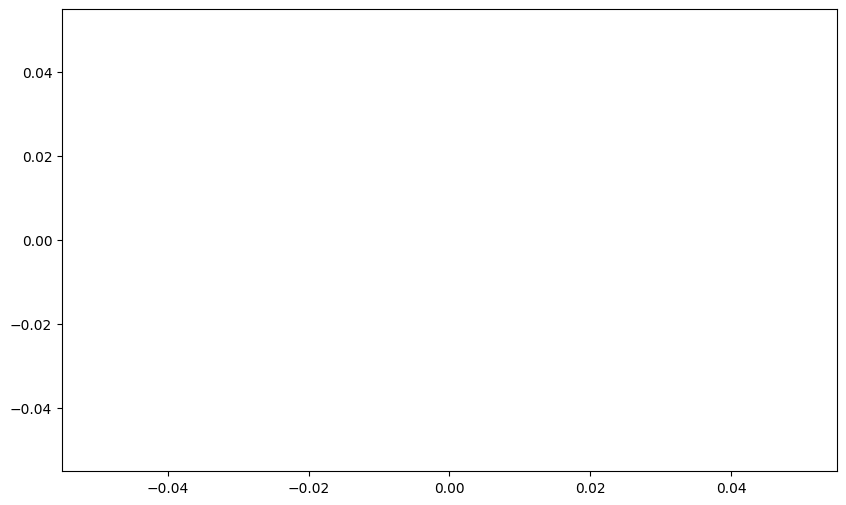

In [7]:
year = 2023

df = pd.read_csv(f'./db_exports/coalitions{year}.csv', header=0)
df["lowest_samples"] = df["lowest_samples"] * (constants.all_voters[year] / 1000000)
exclude_set = set(constants.le_exclude[year])

display(df)

# Filtering rows where 'party_number' is NOT in 'exclude_set'
xx = df[~df['party_number'].isin(exclude_set)]
 
# Determine the min and max range for the bin edges
data_min = min(df["lowest_samples"].min(), xx["lowest_samples"].min())
data_max = max(df["lowest_samples"].max(), xx["lowest_samples"].max())

# Define bin edges with a consistent size
bin_width = 500  # or any other desired width
bin_edges = np.arange(data_min, data_max + bin_width, bin_width)

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot the histogram with consistent bins for 'df' (original data)
sns.histplot(df["lowest_samples"], bins=bin_edges, label='Original Data')

# Plot the histogram with consistent bins for 'xx' (filtered data)
sns.histplot(xx["lowest_samples"], bins=bin_edges, color='orange', label='Filtered Data')

plt.xlabel('Lowest Influential Group Size')
plt.ylabel('Density')
plt.legend()
plt.show()

mean_value = np.mean(df.iloc[:, 2])
std_dev = np.std(df.iloc[:, 2])

print(f"Mean: {mean_value:.2f}, Std Dev: {std_dev:.2f}")

mean_value = np.mean(xx.iloc[:, 2])
std_dev = np.std(xx.iloc[:, 2])

print(f"Mean: {mean_value:.2f}, Std Dev: {std_dev:.2f}")


Year  - Mean: 4, Std Dev: 0
Year hb - Mean: 4, Std Dev: 0
Year dh - Mean: 4, Std Dev: 0


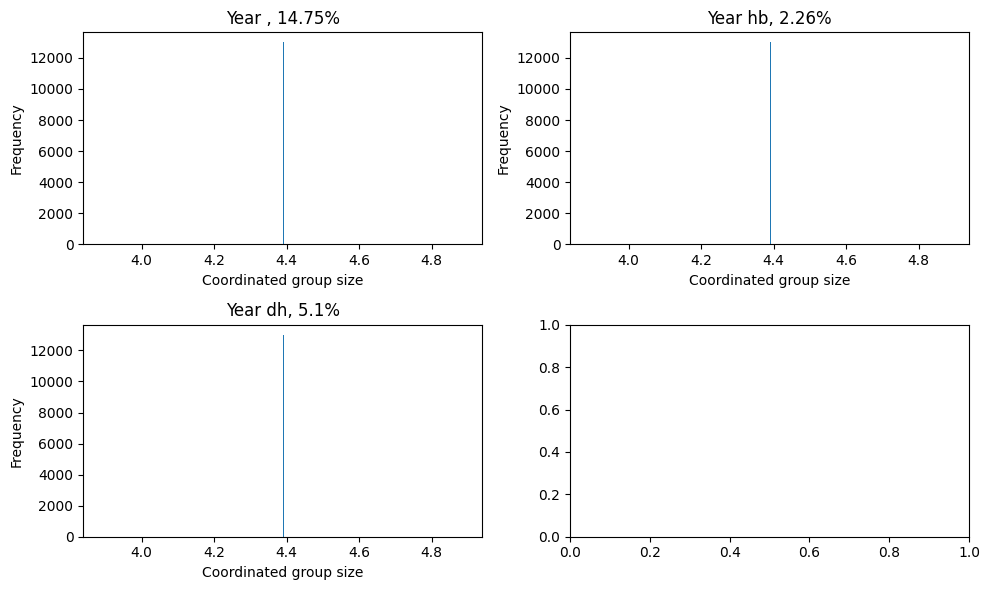

 Mean: 4, Std Dev: 0


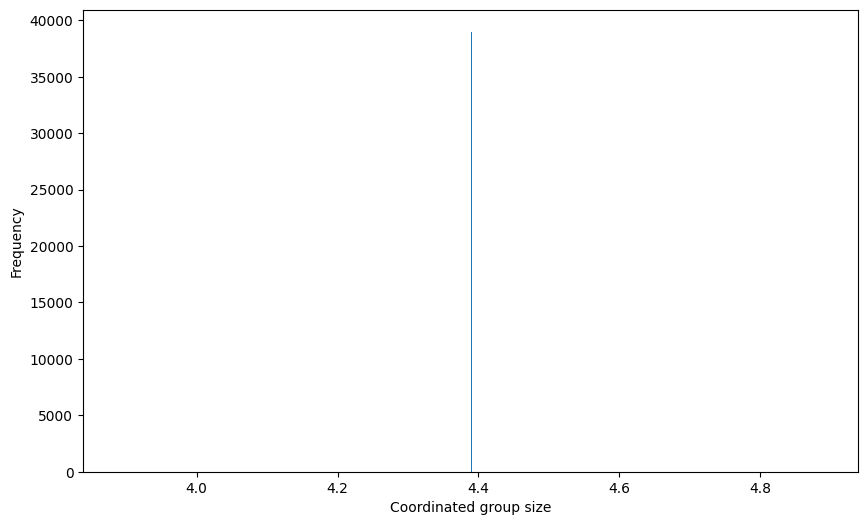

In [ ]:
suffixes = ["", "hb", "dh"]
cumulative_data = []

fig, axs = plt.subplots(2, 2, figsize=(10, 6))

axs = axs.ravel()

j = 0

for i, year in enumerate(suffixes):
    df = pd.read_csv(f'./db_exports/coalitions2023{year}.csv', header=0)
    df["lowest_samples"] = df["lowest_samples"] * (constants.all_voters[2023]/ 1000000)
    
    cumulative_data.extend(df.iloc[:, 2])

    mean_value = np.mean(df.iloc[:, 2])
    std_dev = np.std(df.iloc[:, 2])

    print(f"Year {year} - Mean: {mean_value:.0f}, Std Dev: {std_dev:.0f}")


for i, params in enumerate([("", 14.75), ("hb", 2.26), ('dh', 5.10)]):
    year, perc = params
    df = pd.read_csv(f'./db_exports/coalitions2023{year}.csv', header=0)
    df["lowest_samples"] = df["lowest_samples"] * (constants.all_voters[2023]/ 1000000)
    
    axs[i].hist(df.iloc[:, 2], bins=200)
    axs[i].set_xlabel('Coordinated group size')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(f'Year {year}, {perc}%')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(cumulative_data, bins=500)
plt.xlabel('Coordinated group size')
plt.ylabel('Frequency')

cumulative_mean = np.mean(cumulative_data)
cumulative_std_dev = np.std(cumulative_data)

print(f" Mean: {cumulative_mean:.0f}, Std Dev: {cumulative_std_dev:.0f}")

plt.show()
